# ベイズ推定playground

In [1]:
import sys
sys.path.append('../src')

import bayes_estimation_helper
import importlib
importlib.reload(bayes_estimation_helper)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

helper = bayes_estimation_helper.SensorValueAndTimeWithBayes('../data/range_sensor/sensor_data_600.txt')

shape = (24,)
sum = 0.9999999999999999
0     0.043013
1     0.042916
2     0.042879
3     0.042916
4     0.042964
5     0.043037
6     0.043061
7     0.043001
8     0.038712
9     0.028651
10    0.028736
11    0.043098
12    0.043146
13    0.043025
14    0.043183
15    0.043122
16    0.043061
17    0.043122
18    0.043049
19    0.043086
20    0.043159
21    0.042976
22    0.043049
23    0.043037
Name: 0, dtype: float64


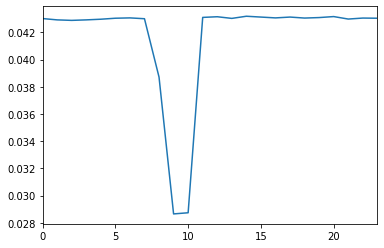

In [2]:
p_t = helper.marginalize_in('t')
print('shape = {}'.format(p_t.shape))
print('sum = {}'.format(p_t.sum()))
print(p_t)
p_t.plot()
plt.show()

shape = (37,)
sum = 1.0
607    0.000012
608    0.000049
609    0.000061
610    0.000328
611    0.000680
612    0.001580
613    0.004241
615    0.007752
616    0.013852
617    0.022053
618    0.031628
619    0.040498
620    0.046585
621    0.050947
622    0.051980
623    0.049319
624    0.046354
625    0.041725
626    0.042648
627    0.043645
628    0.050996
629    0.060121
630    0.066949
631    0.070048
632    0.066901
633    0.059623
634    0.047776
636    0.035370
637    0.022260
638    0.012819
639    0.006671
640    0.002989
641    0.000996
642    0.000401
643    0.000109
644    0.000024
645    0.000012
Name: 0, dtype: float64


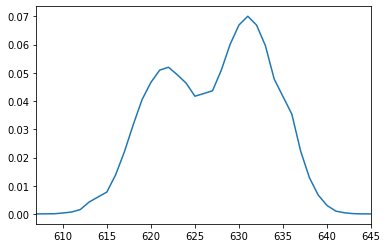

In [3]:
p_z = helper.marginalize_in('z')
print('shape = {}'.format(p_z.shape))
print('sum = {}'.format(p_z.sum()))
print(p_z)
p_z.plot()
plt.show()

shape of joint_z_t = (37, 24)
sum of joint_z_t = 0.9999999999999999


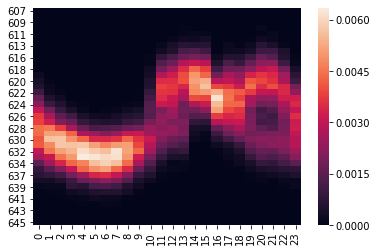

In [4]:
joint_z_t = helper.joint_z_t()
print('shape of joint_z_t = {}'.format(joint_z_t.shape))
print('sum of joint_z_t = {}'.format(joint_z_t.sum().sum()))
sns.heatmap(joint_z_t)
plt.show()

shape of cond_z_t = (37, 24)
sum of cond_z_t = 24.0
sum of cond_z_t[0] = 1.0000000000000002


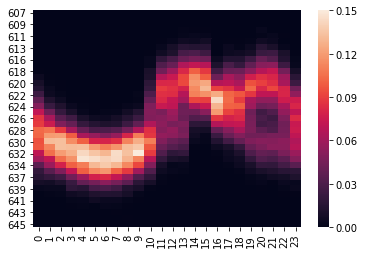

In [5]:
cond_z_t = helper.cond_z_t()
print('shape of cond_z_t = {}'.format(cond_z_t.shape))
print('sum of cond_z_t = {}'.format(cond_z_t.sum().sum()))
print('sum of cond_z_t[0] = {}'.format(cond_z_t[0].sum()))
sns.heatmap(cond_z_t)
plt.show()

shape of cond_t_z = (24, 37)
sum of cond_t_z = 37.0
sum of cond_t_z[0] = 1.0


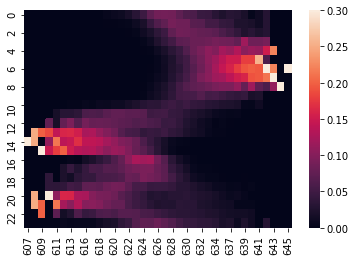

In [6]:
cond_t_z = helper.cond_t_z()
print('shape of cond_t_z = {}'.format(cond_t_z.shape))
print('sum of cond_t_z = {}'.format(cond_t_z.sum().sum()))
print('sum of cond_t_z[0] = {}'.format(cond_t_z[607].sum()))
# 分布が見えやすいように0.3で飽和させている
sns.heatmap(cond_t_z, vmax=0.3)
plt.show()

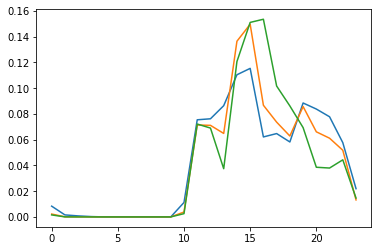

In [7]:
importlib.reload(bayes_estimation_helper)
from bayes_estimation_helper import BayesianFilter
import copy
bf = BayesianFilter(cond_z_t)
updated_p_t = copy.deepcopy(p_t)
# 15時あたりのセンサ値を与えて，それが観測されたと思われる時間を推定する(15時あたりがピークだと良いな)
for z in [620, 622, 624]:
    updated_p_t = bf.update(z, updated_p_t)
    plt.plot(updated_p_t)
plt.show()

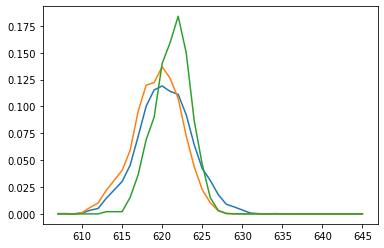

In [8]:
importlib.reload(bayes_estimation_helper)
from bayes_estimation_helper import BayesianFilter
import copy
bf = BayesianFilter(cond_t_z)
updated_p_z = copy.deepcopy(p_z)
# 15時前後の時間を与えて，その時観測されやすいセンサ値を推定する(622付近だと上記と整合する)
for t in [14, 15, 16]:
    updated_p_z = bf.update(t, updated_p_z)
    plt.plot(updated_p_z)
plt.show()